# Проект с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Наша задача - обучить модель, которая будет классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор из 159292 англоязычных комментариев с разметкой о токсичности правок (столбец text содержит текст комментария, а toxic — целевой признак). Значение метрики качества F1 должно быть не меньше 0.75.

Обучение будем проводить на предобученной модели BERT 'bert-base-uncased'.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import transformers
from tqdm import notebook
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from transformers import AdamW, BertTokenizer, BertForSequenceClassification
from IPython.display import clear_output
from tqdm import tqdm, trange
import io
%matplotlib inline

In [2]:
# Подключим GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name()))

Using NVIDIA GeForce GTX 960 GPUs


In [3]:
# Чтение файла
toxic_comments = pd.read_csv(r'C:\Users\taush\Downloads\toxic_comments.csv')

In [4]:
# Получение общей информации о датафрейме
display(toxic_comments.head())
display(toxic_comments.info())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

In [5]:
# Удалим лишний столбец 
toxic_comments = toxic_comments.drop('Unnamed: 0', axis=1)

In [6]:
#toxic_comments = toxic_comments.sample(4000)

In [7]:
#toxic_comments['text'] = toxic_comments['text'].astype('U')

In [8]:
# Вызовем токенизатор текста
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
# Токенизируем текст
# Добавили специальные токены, установили длину в 128 токенов, обрежем и заполним до максимальной длины
tokenized = toxic_comments['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, padding='max_length', truncation=True, max_length=128))

In [10]:
# Переведем токенизированный текст вы массив
# Создадим маски
padded = np.array([i for i in tokenized.values])
attention_masks = [[float(i>0) for i in seq] for seq in padded]

In [11]:
# Создадим целевой признак
labels = toxic_comments['toxic'].values

In [12]:
# Разделим данные и маску на трейн, валидацию и тест
padded_train, padded_valid, labels_train, labels_valid = train_test_split(padded, labels, 
                                                                          test_size=.2, random_state=1234)
padded_valid, padded_test, labels_valid, labels_test = train_test_split(padded_valid, labels_valid, 
                                                                        test_size=.5, random_state=1234)

masks_train, masks_valid, _, _ = train_test_split(attention_masks, padded, test_size=.2, random_state=1234)
masks_valid, masks_test, _, _ = train_test_split(masks_valid, _, test_size=.5, random_state=1234)

In [13]:
# Проверим соотношение выборок
print(padded_train.shape, padded_valid.shape, padded_test.shape)
print(labels_train.shape, labels_valid.shape, labels_test.shape)
print(len(masks_train), len(masks_valid), len(masks_test))

(127433, 128) (15929, 128) (15930, 128)
(127433,) (15929,) (15930,)
127433 15929 15930


In [14]:
# Преобразуем данные в тензоры
padded_train = torch.tensor(padded_train)
padded_valid = torch.tensor(padded_valid)
padded_test = torch.tensor(padded_test)

labels_train = torch.tensor(labels_train)
labels_valid = torch.tensor(labels_valid)
labels_test = torch.tensor(labels_test)

masks_train = torch.tensor(masks_train)
masks_valid = torch.tensor(masks_valid)
masks_test = torch.tensor(masks_test)

In [15]:
# Установим размер batch_size
batch_size = 16

# Подготовим данные с помощью DataLoader
data_train = TensorDataset(padded_train, masks_train, labels_train)
dataloader_train = DataLoader(data_train, sampler=RandomSampler(data_train), batch_size=batch_size)

data_valid = TensorDataset(padded_valid, masks_valid, labels_valid)
dataloader_valid = DataLoader(data_valid, sampler=SequentialSampler(data_valid), batch_size=batch_size)

data_test = TensorDataset(padded_test, masks_test, labels_test)
dataloader_test = DataLoader(data_test, sampler=SequentialSampler(data_test), batch_size=batch_size)

In [16]:
# Вызовем предобученную модель BertForSequenceClassification из модуля transformers
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
# Передадим модель на GPU
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
# Зададим гиперпараметры модели
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [19]:
# Зададим оптимизатор
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

C:\Users\taush\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


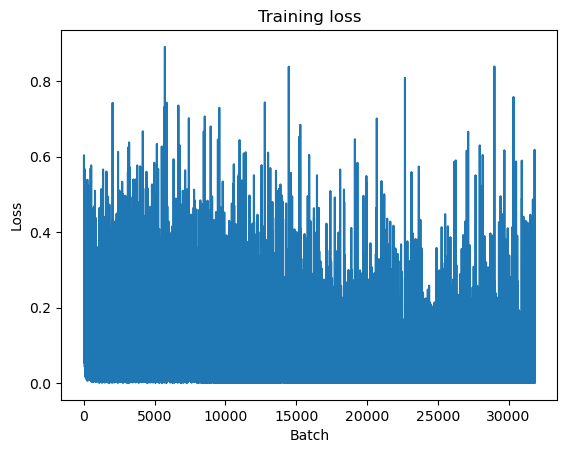

Loss на обучающей выборке: 0.02113


Epoch: 100%|██████████| 4/4 [8:24:50<00:00, 7572.53s/it]  

F-1 на валидационной выборке: 0.8148404993065188
Wall time: 8h 24min 50s


In [20]:
%%time
# Сохраним loss во время обучения и отрисуем график
train_loss_set = []

# Зададим количество эпох
epochs = 4

for _ in trange(epochs, desc='Epoch'):
    # Переведем модель в режим обучения
    model.train()
    
    train_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(dataloader_train):
        # Добавляем batch для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        # Распакуем данные из dataloader
        batch_padded, batch_mask, batch_labels = batch
    
        # Обнуляем градиент
        optimizer.zero_grad()
        
        # Передадим модели данные, маску и labels для вычисления ошибки   
        loss = model(batch_padded, token_type_ids=None, attention_mask=batch_mask, labels=batch_labels)
    
        train_loss_set.append(loss[0].item())
        # вычислим градиент     
        loss[0].backward()
        # Обновляем параметры и делаем шаг оптимизации    
        optimizer.step()
    
        # Обновляем loss
        train_loss += loss[0].item()
        nb_tr_examples += batch_padded.size(0)
        nb_tr_steps += 1
    
        # Рисуем график
        clear_output(True)
        plt.plot(train_loss_set)
        plt.title('Training loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.show()
    
    print(f'Loss на обучающей выборке: {train_loss/nb_tr_steps:.5}')
    
    
    # Переводим модель в режим предсказания
    model.eval()

    valid_preds, valid_labels = [], []

    # Оценим данные для одной эпохи
    for batch in dataloader_valid:
        # Добавляем batch для вычисления на GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Распакуем данные из dataloader
        batch_padded, batch_mask, batch_labels = batch
        
        # Укажем, что градиент не нужен
        with torch.no_grad():
            # Вычисляем предсказания
            logits = model(batch_padded, token_type_ids=None, attention_mask=batch_mask)
    
        # Перемещаем logits и labels на CPU
        logits = logits[0].detach().cpu().numpy()
        labels = batch_labels.detach().cpu().numpy()

        batch_preds = np.argmax(logits, axis=1)
        # Объединим labels
        batch_labels = np.concatenate([labels], axis=0)
        # Добавим batch_preds в valid_preds, batch_labels в valid_labels
        valid_preds.extend(batch_preds)
        valid_labels.extend(batch_labels)
        
    print('F-1 на валидационной выборке:', f1_score(valid_labels, valid_preds))

Обучив модель на обучающей выборке и получив предсказания на валидационной выборке (10%), с 4 эпохахами, мы получили значение F1 - 0.814. Проведем тестирование модели на отложенных данных.

### Тестирование модели

Токенизируем текст тестовой выборки, создадим педдинги и маску. Сделаем предсказание моделью BertForSequenceClassification на тестовой выборке, расчитаем значение F1.

In [21]:
model.eval()
test_preds, test_labels = [], []
    
for batch in dataloader_test:
    batch = tuple(t.to(device) for t in batch)
    batch_padded, batch_mask, batch_labels = batch
    with torch.no_grad():
        logits = model(batch_padded, token_type_ids=None, attention_mask=batch_mask)
    logits = logits[0].detach().cpu().numpy()
    labels = batch_labels.detach().cpu().numpy()
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate([labels], axis=0)
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)      
    
print('F-1 на тестовой выборке:', f1_score(test_labels, test_preds))

F-1 на тестовой выборке: 0.8362097036795831


Значение F1-меры на тестовых данных составляет 0.836. Разрабочиками модели рекомендуется количество эпох устанавливать от 2 до 4.

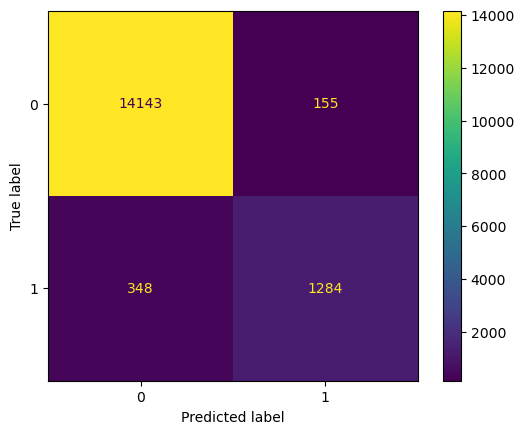

In [22]:
# Посмотрим на матрицу ошибок
matrix = confusion_matrix(test_labels, test_preds)
cm_display = ConfusionMatrixDisplay(matrix).plot()

Модель BertForSequenceClassification отлично справляется с задачей классификации токсичности англоязычных комментариев. Модель  на тестовых данных размером 15930 англоязычных комментариев предсказала целевой признак с точностью 96%, значение F1-меры - 0.836, что соответствует условиям заказчика. При этом модель допустила ошибки: ошибка первого роды FP - 155, ошибка второго рода FN - 348. 